In [6]:
## Import packages and functions needed to plot and access the NOMAD Data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import glob
import csv
import re
from matplotlib.backends.backend_pdf import PdfPages
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from api_calls_get_data import get_specific_data_of_sample, get_entryid, get_quantity_over_jv


In [7]:
def get_filenames(path):
    sample_ids = set()  # Use a set to store IDs
    
    pattern = r"(.*)\.px\d+\.jv\.csv"
    
    # Go through all files in the directory
    for file in glob.iglob(os.path.join(path, "*.jv*")):    
        # Extract ID from filename
        filename = os.path.basename(file)
        match = re.match(pattern, filename)
        if match:
            sample_ids.add(match.group(1))  # Add to set, duplicates are ignored
                
    return sample_ids

In [9]:

def get_batch_data(sample_ids):
    #Get the NOMAD ID
    samples_of_batch = [(sample_id, get_entryid(sample_id)) for sample_id in sample_ids]

    #Process in which the quantity was changed
    #TODO Make this a variable input as dropdown menu
    key = ["peroTF_CR_SpinBox_SpinCoating"]
    
    #Varied quantities to extract 
    #TODO Make this a variable input as dropdown menu
    quantities=["name"]
    
    #Standard JV parameters to get
    jv_quantities=["efficiency",\
                   "fill_factor",\
                   "open_circuit_voltage",\
                   "short_circuit_current_density"]
    
    #Get data
    df = get_quantity_over_jv(samples_of_batch, key, quantities, jv_quantities)
    
    #Extract Information from ID
    df['last_digit'] = df['sample_id'].str.extract('(\d)$').astype(int)[0]
    df['category'] = df['sample_id'].str.split('_').str[4]
    df['batch_name'] = df['sample_id'].str.split('_').str[3]
    df['batch_date'] = df['sample_id'].str.split('_').str[2]

    # Data cleaning remove shunted or somehow damaged devices using filters
    df = df[df['fill_factor'] >= 0.3]
    df = df[df['open_circuit_voltage'] >= 0.5]
    df = df[df["fill_factor"] <= 1]


    return df, quantities

In [124]:
def calculate_statistics(df, quantities):    

    result_df = pd.DataFrame(columns=['category',
                                      'standard_deviation',
                                      'median',
                                      'closest_median',
                                      'closest_median_id',
                                      'maximum_efficiency',
                                      'maximum_efficiency_id'])

    for index, category in enumerate(sorted(df[quantities[0]].unique())):
        # Calculate standard deviation
        std_dev = df[df[quantities[0]] == category]['efficiency'].std()
        # Median and closest value to median
        med_eff = df[df[quantities[0]] == category]['efficiency'].median()
        closest_med_eff_value = sorted(df[df[quantities[0]] == category]['efficiency'],
                                       key=lambda x: abs(x - med_eff - 0.000000001))[:1]
        med_id = df[df['efficiency'] == closest_med_eff_value[0]]['sample_id'].values[0]
        # Maximum efficiency value
        max_eff = df[df[quantities[0]] == category]['efficiency'].max()
        max_id = df[df['efficiency'] == max_eff]['sample_id'].values[0]

        # Create a temporary DataFrame with the current results
        temp_df = pd.DataFrame({
            'category': [category],
            'standard_deviation': [np.round(std_dev,2)],
            'median': [np.round(med_eff)],
            'closest_median': [closest_med_eff_value[0]],
            'closest_median_id': [med_id],
            'maximum_efficiency': [max_eff],
            'maximum_efficiency_id': [max_id]
            })

        # Concatenate the temporary DataFrame with the result DataFrame
        result_df = pd.concat([result_df, temp_df], ignore_index=True)

    # Perform ANOVA test
    f_statistic, p_value = f_oneway(*[group['efficiency'] for name, group in df.groupby(quantities[0])])

    if p_value < 0.05:
        # Perform Tukey HSD test
        tukey_results = pairwise_tukeyhsd(df['efficiency'], df[quantities[0]], alpha=0.05)
        print(tukey_results)
    else:
        print("No significant differences between group means.")
            
    return result_df



In [110]:

def plot_JV_curves(result_df, curve_type):
    fig, ax = plt.subplots()
    
    # Define a color palette for the groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(result_df)))
    
    # Set the color cycle for the axes
    ax.set_prop_cycle(color=colors)
    
    for index, row in result_df.iterrows():
        jv_data = get_specific_data_of_sample(row[f'{curve_type}_id'], "JVmeasurement")
        for cell in jv_data:
            for i in range(2):
                if cell["jv_curve"][i]["efficiency"] == row[f'{curve_type}'] and \
                   (curve_type == 'maximum_efficiency' or curve_type == 'closest_median'):
                        ax.plot(cell["jv_curve"][i]["voltage"], \
                                 cell["jv_curve"][i]["current_density"], \
                                 label=f"{row['category']}")
                        print(cell["name"])
                        break

    # Plot settings
    ax.legend()
    ax.set_xlim(-0.2, 1.3)
    ax.set_ylim(-5, 25)
    ax.set_title(f'{curve_type.capitalize()} JV Curves', fontsize=16)
    ax.set_xlabel('Voltage (V)', fontsize=12)
    ax.set_ylabel('Current Density(mA/cm²)', fontsize=12)

    # Axis ticks and borders
    ax.tick_params(axis='both', which='both', direction='in', width=2, bottom=1, top=1, left=1, right=1)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    # Zero lines
    ax.axhline(y=0, color='black', linewidth=0.5)
    ax.axvline(x=0, color='black', linewidth=0.5)
    
    #fig.savefig(f"{curve_type}.png", dpi=300, transparent=True, bbox_inches='tight')

    return fig

In [12]:
def plot_box_and_scatter(df, quantities, jv_quantity):
    # Define a color palette for the groups
    colors = plt.cm.viridis(np.linspace(0, 1, len(df[quantities[0]].unique())))
    
    # Define Y-Axis Labels
    quantity_labels = {
        'open_circuit_voltage': 'Open Circuit Voltage (V)',
        'fill_factor': 'Fill Factor (%)',
        'efficiency': 'Efficiency (%)',
        'short_circuit_current_density': 'Short Circuit Current Density (mA/cm²)'
    }

    fig, ax = plt.subplots(figsize=(10, 5))

    positions = [i + 1 for i in range(len(df[quantities[0]].unique()))]  # Define positions for each group

    # Draw the box plot without fliers and with colors
    boxprops = dict(facecolor='white', color='black')
    medianprops = dict(color='red')
    for i, (group, color) in enumerate(zip(df[quantities[0]].unique(), colors)):
        group_data = df[df[quantities[0]] == group][jv_quantity]
        box = ax.boxplot(group_data, positions=[positions[i]], showmeans=False, showfliers=False, widths=0.5, patch_artist=True,
                          boxprops=dict(facecolor=color, color='black'),
                          medianprops=medianprops)

    # Overlay the scatter plot with black points
    for i, group in enumerate(df[quantities[0]].unique()):
        group_data = df[df[quantities[0]] == group]
        # Add jitter to x positions
        jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(group_data))
        ax.scatter(jittered_x, group_data[jv_quantity], color='black', alpha=1, zorder=3)

    # Axis label and Ticks
    ax.set_ylabel(f"{quantity_labels[jv_quantity]}", size=16)
    ax.set_xticks(positions)
    ax.set_xticklabels(df[quantities[0]].unique(), size=14)
    ax.set_yticks(ax.get_yticks())
    ax.tick_params(axis='both', labelsize=14)

    # Border line and Ticks Formatting
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(axis='both', right=True, top=True, direction='in', width=2, colors='black', length=5)

    # Transparent Background
    fig.patch.set_facecolor('none')
    ax.patch.set_facecolor('none')

    # Save the figure
    #fig.savefig(f"{jv_quantity}.png", dpi=300, transparent=True, bbox_inches='tight')

    return fig


In [111]:
def generate_pdf_report(result_df, df, quantities, report_title):
    with PdfPages(report_title) as pdf:
        # Plot the maximum JV curves
        fig_max = plot_JV_curves(result_df, 'maximum_efficiency')
        pdf.savefig(fig_max, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_max)

        # Plot the median JV curves
        fig_med = plot_JV_curves(result_df, 'closest_median')
        pdf.savefig(fig_med, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_med)

        # Add any other plots or content to the PDF here
        fig_eff = plot_box_and_scatter(df, [quantities[0]], 'efficiency')
        pdf.savefig(fig_eff, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_eff)
        
        fig_ff = plot_box_and_scatter(df, [quantities[0]], 'fill_factor')
        pdf.savefig(fig_ff, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_ff)
        
        fig_voc = plot_box_and_scatter(df, [quantities[0]], 'open_circuit_voltage')
        pdf.savefig(fig_voc, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_voc)
        
        fig_jsc = plot_box_and_scatter(df, [quantities[0]], 'short_circuit_current_density')
        pdf.savefig(fig_jsc, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_jsc)
        
        # Add result_df as a table to the PDF
        fig_table, ax_table = plt.subplots(figsize=(10, 5))
        ax_table.axis('off')  # Hide axis
        table = ax_table.table(cellText=round(result_df.values,2), colLabels=result_df.columns, loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        pdf.savefig(fig_table, dpi=300, transparent=True, bbox_inches='tight')
        plt.close(fig_table)

    print("PDF report generated successfully.")

In [128]:
path = "//129.13.79.200/AG_Lemmer$/Forschungsprojekte/Spektroskopie/Perovskite solar cells/Data/SonSim/Daniel/WBG-Tandem/SAM3H/"

In [104]:
def main():
    root = tk.Tk()
    root.withdraw()
    path = filedialog.askdirectory(title="Select Directory")
    if not path:
        print("No directory selected")
        return

    sample_ids = get_filenames(path)
    df, quantities = get_batch_data(sample_ids)
    result_df = calculate_statistics(df, quantities)
    generate_pdf_report(result_df, df, [quantities[0]])
    
    print("ALL TASKS COMPLETED")




In [152]:
sample_ids = {'KIT_DaBa_20241107_SAM-3H_0_0'}
sample_ids = get_filenames(path)
sample_ids

{'KIT_DaBa_20241107_SAM-3H_0_0',
 'KIT_DaBa_20241107_SAM-3H_0_1',
 'KIT_DaBa_20241107_SAM-3H_0_2',
 'KIT_DaBa_20241107_SAM-3H_0_3',
 'KIT_DaBa_20241107_SAM-3H_1_1',
 'KIT_DaBa_20241107_SAM-3H_1_2',
 'KIT_DaBa_20241107_SAM-3H_1_3',
 'KIT_DaBa_20241107_SAM-3H_2_0',
 'KIT_DaBa_20241107_SAM-3H_2_1',
 'KIT_DaBa_20241107_SAM-3H_2_2',
 'KIT_DaBa_20241107_SAM-3H_2_3',
 'KIT_DaBa_20241107_SAM-3H_3_0',
 'KIT_DaBa_20241107_SAM-3H_3_1',
 'KIT_DaBa_20241107_SAM-3H_3_2',
 'KIT_DaBa_20241107_SAM-3H_3_3'}

In [153]:
samples_of_batch = [(sample_id, get_entryid(sample_id)) for sample_id in sample_ids]
samples_of_batch

[('KIT_DaBa_20241107_SAM-3H_2_0', 'pggKo43y6HJeI_KbWlQ6dD3ZChgh'),
 ('KIT_DaBa_20241107_SAM-3H_0_2', 'eNS7ysMDi3IkoDgV4GPig_vnChuM'),
 ('KIT_DaBa_20241107_SAM-3H_0_1', 's18GHd3xaPSPF2JkSkxAxrmRqit9'),
 ('KIT_DaBa_20241107_SAM-3H_3_0', '431enrvg8U3labDRKPz1Izoxuu0O'),
 ('KIT_DaBa_20241107_SAM-3H_1_3', 'yConVFGIInyuQOqBWwO04SFXp7WS'),
 ('KIT_DaBa_20241107_SAM-3H_2_3', 'k5uPe-WnuAL-SotyjEJveLlQFRZ-'),
 ('KIT_DaBa_20241107_SAM-3H_3_2', 'LP1ZVSb_RYDoBXNXjgcdqMgCn5PE'),
 ('KIT_DaBa_20241107_SAM-3H_0_3', 'GRLlVHBguFhLsoQz6r-83oDo1sxm'),
 ('KIT_DaBa_20241107_SAM-3H_1_1', 'HbIdFBlFDgWM3WpQbvdsJZ1V3cTR'),
 ('KIT_DaBa_20241107_SAM-3H_1_2', 'n7qel7BjipsKZ9lEMKA9zHLyruU0'),
 ('KIT_DaBa_20241107_SAM-3H_3_3', '4AsLaa6qo_HPdQyAaV4AeDldoV1I'),
 ('KIT_DaBa_20241107_SAM-3H_3_1', 'NL_jDGAYO8X1N9SGekd6wQWyp8r7'),
 ('KIT_DaBa_20241107_SAM-3H_0_0', 'SHb05d0Sxy589rsrkYilsS3CiMIP'),
 ('KIT_DaBa_20241107_SAM-3H_2_2', 'X7HWz5js7zN6RFs8PS3ojcTKgh6_'),
 ('KIT_DaBa_20241107_SAM-3H_2_1', '00KxVIm3GcFx9upw86ZsRats-_v

No significant differences between group means.
KIT_DaBa_20241107_SAM-3H_0_3 px2
KIT_DaBa_20241107_SAM-3H_2_2 px3
KIT_DaBa_20241107_SAM-3H_1_2 px3
KIT_DaBa_20241107_SAM-3H_3_1 px4
KIT_DaBa_20241107_SAM-3H_0_0 px4
KIT_DaBa_20241107_SAM-3H_2_3 px3
KIT_DaBa_20241107_SAM-3H_1_1 px2
KIT_DaBa_20241107_SAM-3H_3_0 px4


TypeError: type numpy.ndarray doesn't define __round__ method

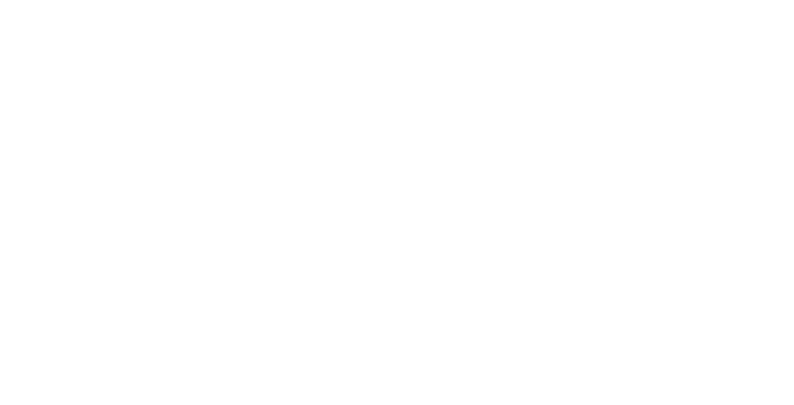

In [154]:

    df, quantities = get_batch_data(sample_ids)
    result_df = calculate_statistics(df, quantities)
    generate_pdf_report(result_df, df, [quantities[0]], "SAM-3H.pdf")

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
WBG 3C (2PACz)   WBG 3C (MeO)  -2.3473    0.0 -3.4175  -1.277   True
WBG 3C (2PACz) WBG 3H (2PACz)  -4.5898    0.0 -5.9007  -3.279   True
WBG 3C (2PACz)   WBG 3H (MeO)  -0.0694 0.9989 -1.3272  1.1883  False
  WBG 3C (MeO) WBG 3H (2PACz)  -2.2426 0.0003 -3.6144 -0.8708   True
  WBG 3C (MeO)   WBG 3H (MeO)   2.2778 0.0001  0.9566   3.599   True
WBG 3H (2PACz)   WBG 3H (MeO)   4.5204    0.0  2.9978   6.043   True
--------------------------------------------------------------------
KIT_DaBa_20241120_SAM-3H-2_0_2 px3
KIT_DaBa_20241120_SAM-3H-2_2_3 px1
KIT_DaBa_20241120_SAM-3H-2_1_3 px4
KIT_DaBa_20241120_SAM-3H-2_3_2 px1
KIT_DaBa_20241120_SAM-3H-2_0_4 px1
KIT_DaBa_20241120_SAM-3H-2_2_3 px3
KIT_DaBa_20241120_SAM-3H-2_1_3 px1
KIT_DaBa_20241120_SAM-3H-2_3_3 px4


TypeError: type numpy.ndarray doesn't define __round__ method

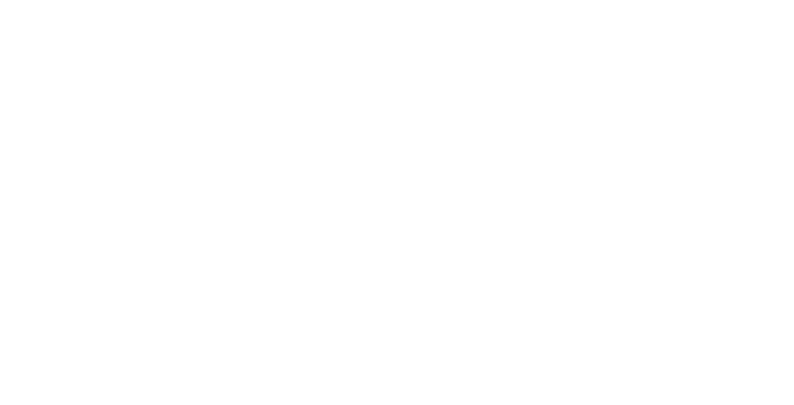

In [ ]:
    sample_ids = get_filenames(path)
    df, quantities = get_batch_data(sample_ids)
    result_df = calculate_statistics(df, quantities)
    generate_pdf_report(result_df, df, [quantities[0]], "SAM2H-2.pdf")
